In [2]:
import os
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

/Users/ericwang0912/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Download and cache model/tokenizer (requires internet)
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert")
model = AutoModel.from_pretrained("Rostlab/prot_bert")

# Save to disk
tokenizer.save_pretrained("model/protbert_model")
model.save_pretrained("model/protbert_model")

In [4]:
model_path = "model/protbert_model"

tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
model = AutoModel.from_pretrained(model_path, local_files_only=True)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, i

In [5]:
def prepare_protbert_input(seq):
    # 将蛋白质序列转为 "M A C P A L ..." 的形式
    return " ".join(list(seq.strip()))

In [6]:
df = pd.read_csv("data/cancer_data_preprocessed.csv")

clinical_features = [
    "Cancer Type", "Histology Abbreviation",
    "Donor Age at Diagnosis", "Donor Sex",
    "Donor Vital Status", "Donor Survival Time",
    "Tumour Grade", "Cancer Stage"
]

df = df[clinical_features].dropna()

# 标签编码
le = LabelEncoder()
df["label"] = le.fit_transform(df["Cancer Stage"])

In [7]:
print("Number of samples:", len(df))
print(df.columns.tolist())

Number of samples: 38258
['Cancer Type', 'Histology Abbreviation', 'Donor Age at Diagnosis', 'Donor Sex', 'Donor Vital Status', 'Donor Survival Time', 'Tumour Grade', 'Cancer Stage', 'label']


In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

categorical_cols = [
    "Cancer Type", "Histology Abbreviation",
    "Donor Sex", "Donor Vital Status", "Tumour Grade"
]
numerical_cols = [
    "Donor Age at Diagnosis", "Donor Survival Time"
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Extract X and y
X_np = preprocessor.fit_transform(df.drop(columns=["label"]))
y_np = df["label"].values

# Convert to PyTorch tensors
X = torch.tensor(X_np.toarray() if hasattr(X_np, "toarray") else X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.long)

In [9]:
X_np, y_np = X.numpy(), y.numpy()

X_train, X_temp, y_train, y_temp = train_test_split(
    X_np, y_np, test_size=0.3, stratify=y_np, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_val, y_val = torch.tensor(X_val), torch.tensor(y_val)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

In [10]:
class ProteinClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cls = ProteinClassifier(X.shape[1], len(le.classes_)).to(device)
optimizer = torch.optim.AdamW(model_cls.parameters(), lr=2e-4)
loss_fn = nn.CrossEntropyLoss()

EPOCHS = 50
for epoch in range(EPOCHS):
    model_cls.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model_cls(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # 验证
    model_cls.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model_cls(xb)
            loss = loss_fn(out, yb)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/50 | Train Loss: 583.6040 | Val Loss: 42.1529
Epoch 2/50 | Train Loss: 346.4268 | Val Loss: 30.4643
Epoch 3/50 | Train Loss: 271.6152 | Val Loss: 24.2521
Epoch 4/50 | Train Loss: 235.1962 | Val Loss: 20.5787
Epoch 5/50 | Train Loss: 208.8599 | Val Loss: 18.3669
Epoch 6/50 | Train Loss: 187.7918 | Val Loss: 16.5472
Epoch 7/50 | Train Loss: 172.4081 | Val Loss: 15.4194
Epoch 8/50 | Train Loss: 160.2168 | Val Loss: 14.1704
Epoch 9/50 | Train Loss: 149.8162 | Val Loss: 12.8888
Epoch 10/50 | Train Loss: 140.1605 | Val Loss: 11.8802
Epoch 11/50 | Train Loss: 131.9062 | Val Loss: 11.2991
Epoch 12/50 | Train Loss: 122.1174 | Val Loss: 10.5846
Epoch 13/50 | Train Loss: 115.0730 | Val Loss: 9.9155
Epoch 14/50 | Train Loss: 107.4771 | Val Loss: 9.0035
Epoch 15/50 | Train Loss: 101.0107 | Val Loss: 8.4574
Epoch 16/50 | Train Loss: 95.4915 | Val Loss: 7.8512
Epoch 17/50 | Train Loss: 88.9205 | Val Loss: 7.3834
Epoch 18/50 | Train Loss: 84.3913 | Val Loss: 7.5385
Epoch 19/50 | Train Loss: 81

In [12]:
model_cls.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model_cls(xb).argmax(dim=1).cpu()
        all_preds.extend(preds)
        all_labels.extend(yb)

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="macro")
print(f"✅ Test Accuracy: {acc:.4f}, Macro F1: {f1:.4f}")

✅ Test Accuracy: 1.0000, Macro F1: 1.0000


In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
all_preds_np = np.array(all_preds)
all_labels_np = np.array(all_labels)

cm = confusion_matrix(all_labels_np, all_preds_np)

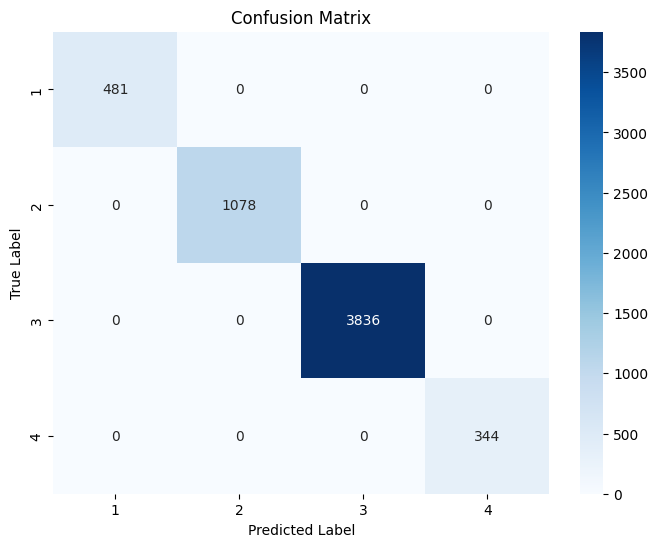

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [16]:
torch.save(model_cls.state_dict(), "outputs/protbert_classifier.pt")
print("✅ 模型已保存到 outputs/protbert_classifier.pt")

✅ 模型已保存到 outputs/protbert_classifier.pt
